In [2]:
import sympy
from sympy.core.symbol import symbols, Symbol
from sympy import Abs
from sympy.printing import latex, pprint
from sympy import Symbol, simplify, collect, expand, apart, together, factor
from sympy import dsolve, Function, Derivative, integrate, diff
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, EngFormatter
from copy import copy, deepcopy
from math import log10
from PyLTSpice import LTSpice_RawRead
from math import log10
import logging
from ipywidgets import FloatSlider, FloatLogSlider, interact, interactive
from converter5 import *
from scipy.optimize import minimize

Found Numpy. WIll be used for storing data


In [3]:
Lf = symbols('L_f', real=True, positive=True)
Cf = symbols('C_f' ,real=True, positive=True)
Cd = symbols('C_d', real=True, positive=True)
Vg = symbols('V_g' ,real=True, positive=True)
Rd = symbols('R_d' ,real=True, positive=True)
s = symbols('s')
j = sympy.sqrt(-1)
w = symbols('omega')
Z_Lf = s*Lf
Z_Cf = 1/(s*Cf)
Z_Cd = 1/(s*Cd)


In [4]:
def parallel(x, y):
    return x*y/(x+y)


In [5]:
Zb = parallel(Z_Cf, Z_Cd+Rd)
Zt = Z_Lf
Vout = Vg * Zb/(Zb+Zt)
Vout = Vout.simplify()
H = Vout/Vg
display(collect(H, s))
num, den = H.as_numer_denom() 

(C_d*R_d*s + 1)/(C_d*R_d*s + L_f*s**2*(C_d*C_f*R_d*s + C_d + C_f) + 1)

In [6]:
def get_as(num):
    #Construct coefficients for a polynomial of degree num
    a_s = [Symbol('a_{}'.format(i)) for i in range(num, 0, -1)]
    return a_s

def display_coefficients(expr):
    coeffs = expr.as_poly(s).coeffs()
    order = len(coeffs) - 1 #we don't want to count the constant term
    m = zip(coeffs, get_as(order)) #zip stops after first iterable is exhausted
    #the arguments to zip above don't have the same length
    n = deepcopy(m) #make a copy so we can display the result 
    #but still return an unexhausted zip object
    for pair in n: 
        myprint(pair[1], pair[0])
    return m 


def make_poly(coeffs):
    s = symbols('s')
    try: 
        return (1+s/coeffs.pop())*make_poly(coeffs)
    except IndexError:
        return 1
    
    
m = display_coefficients(den)

def low_q(expr):
    num, den = expr.as_numer_denom() 
    num_coeffs = num.as_poly(s).coeffs()
    den_coeffs = den.as_poly(s).coeffs()
    new_den_coeffs = [simplify(pair[1]/pair[0]) for pair in zip(den_coeffs, den_coeffs[1:]+[1])]
    new_num_coeffs = [simplify(pair[1]/pair[0]) for pair in zip(num_coeffs, num_coeffs[1:]+[1])]
    return make_poly(new_num_coeffs)/make_poly(new_den_coeffs)
            
H_approx = low_q(H)
display(H_approx)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

1/((1 + L_f*s*(C_d + C_f)/(C_d*R_d))*(C_d*C_f*R_d*s/(C_d + C_f) + 1))

In [7]:

max_f = 1e6
min_f = 1e2
freqs_f = np.logspace(np.log10(min_f), np.log10(max_f)) # freqs in Hz
freqs_w = 2*np.pi*freqs_f 

def mag(Rd_, Cd_):
    Vout_ = Vout.subs({Vg:1, Cf: 1e-6, Lf:1e-6, Rd: Rd_, Cd:Cd_})
    t = lambdify(list(Vout_.atoms(Symbol)), Vout_)
    return 20*np.log10(np.abs(t(j*freqs_w)).astype(np.float64))

def low_q_mag(Rd_, Cd_):
    H_ = H_approx.subs({Vg:1, Cf: 1e-6, Lf:1e-6, Rd: Rd_, Cd:Cd_})
    t = lambdify(list(H_.atoms(Symbol)), H_)
    return 20*np.log10(np.abs(t(j*freqs_w)).astype(np.float64))

def phase(Rd_, Cd_):

    Vout_ = Vout.subs({Vg:1, Cf: 1e-6, Lf:1e-6, Rd: Rd_, Cd:Cd_})
    t = lambdify(list(Vout_.atoms(Symbol)), Vout_)
    return np.angle(t(freqs).astype(complex), deg=True)
    

In [8]:
H_ = H.subs({Vg:1, Cf: 1e-6, Lf:1e-6, Rd: .1, Cd:.1e-6})
t = lambdify(list(H_.atoms(Symbol)), H_)
#t?

<IPython.core.display.Javascript object>


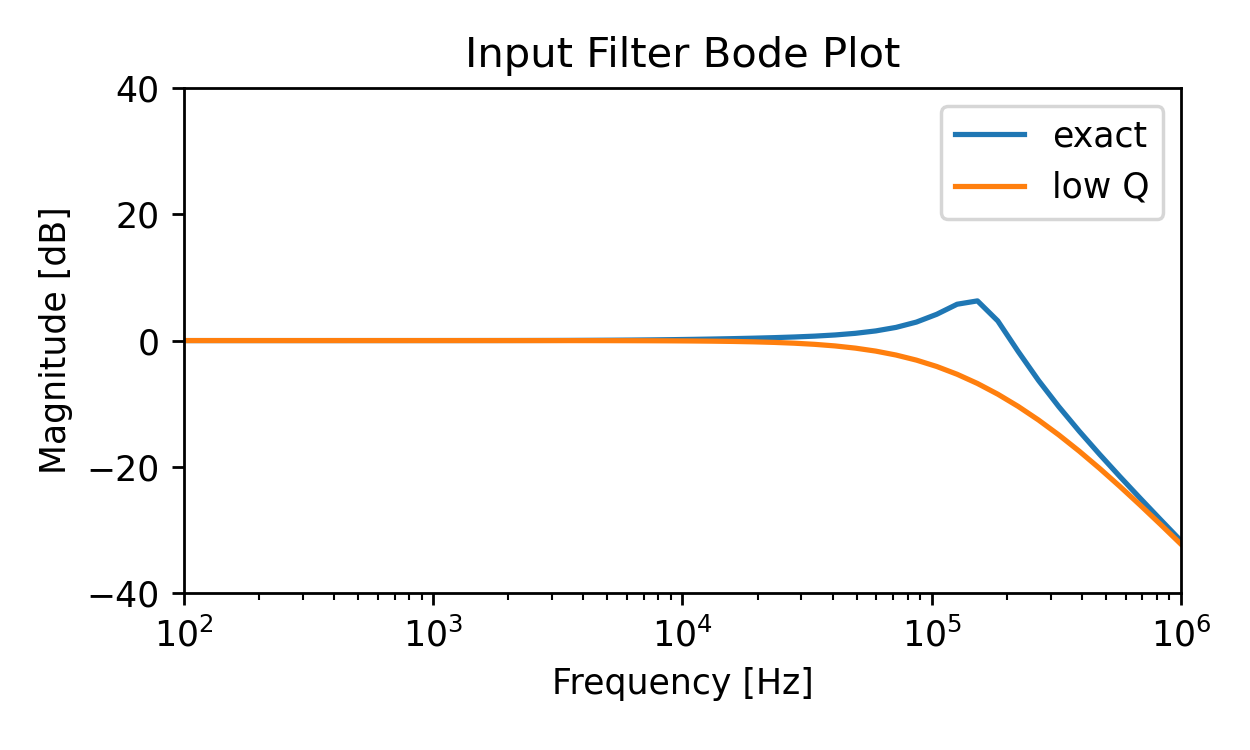

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Rd_', max=2.1, min=0.01, r…

In [9]:
%matplotlib notebook
#doesn't work with inline backend

max_R = 2.1
min_R = .01
max_C =40e-6
min_C = 1e-6
r_widget = FloatSlider(min=min_R, max=max_R, step=.02, readout_format='.3f', continuous_update=False)
c_widget = FloatSlider(min=min_C, max=max_C, step=5e-6, readout_format='.1e', continuous_update=False)

fig, ax = plt.subplots(subplot_kw={'title':'Input Filter Bode Plot'}, figsize=(5,3))
ax.set_ylim(bottom= -40, top=40)
ax.set_xlim(left=100, right=1e6)
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Frequency [Hz]')

l, = ax.semilogx(freqs_f, mag(min_R, min_C), label='exact')
l_approx, = ax.semilogx(freqs_f, low_q_mag(min_R, min_C), label='low Q')
ax.legend()
fig.tight_layout()
def g(Rd_, Cd_):
    
    l.set_ydata(mag(Rd_, Cd_))
    l_approx.set_ydata(low_q_mag(Rd_, Cd_))
    fig.canvas.draw()

interactive_plot = interactive(g, Rd_ = r_widget, Cd_=c_widget)
interactive_plot

In [10]:
#Vout = Vout.subs({Vg:1, Cf: 10e-6, Lf:1e-6, Rd: 1, Cd:1e-6})
t = lambdify([Rd, Cd], Vout.subs({Vg:1, Cf: 10e-6, Lf:1e-6, s: j*50e3}))
def newt(x):
    return np.abs(t(x[0], x[1]))
    

In [11]:
t?

In [13]:

minimize(newt, [1, 80e-6], bounds = [(1e-3, 3), (.1e-6, 30e-6)])

      fun: 1.0292297035952584
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.29187781e-03, -1.13776110e+02])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([3.e+00, 3.e-05])

In [14]:
Rd_ = np.linspace(min_R, max_R, 10)
Cd_ = np.linspace(min_C, max_C, 10)
Rd_, Cd_ = np.meshgrid(Rd_, Cd_)

def mag2(s_):
    Vout_ = Vout.subs({Vg:1, Cf: 10e-6, Lf:1e-6,s:s_})#, Rd: Rd_, Cd:Cd_})
    t = lambdify([Rd, Cd], Vout_)
    return 20*np.log10(np.abs(t(Rd_, Cd_)))

<IPython.core.display.Javascript object>


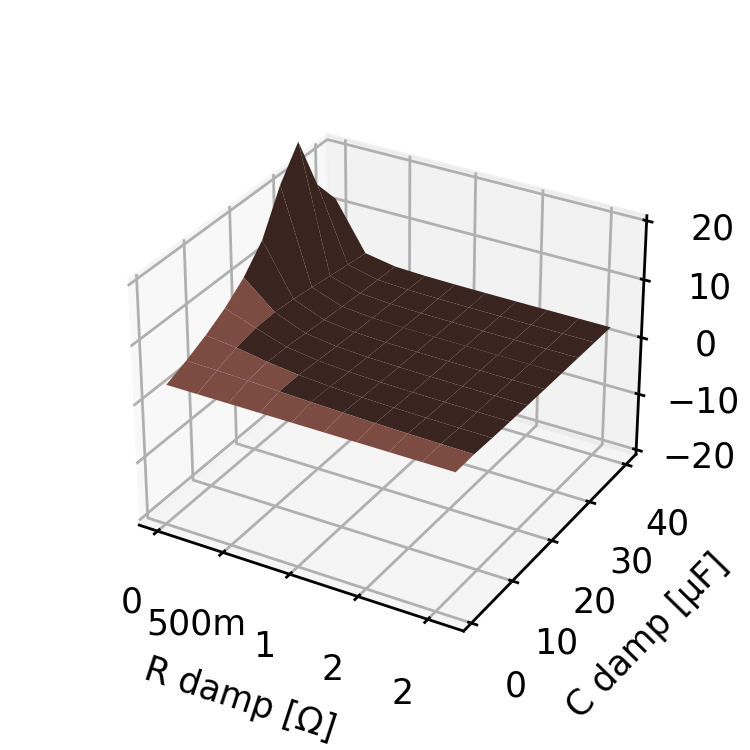

interactive(children=(FloatLogSlider(value=1000.0, continuous_update=False, description='freq', max=5.0, min=3…

In [18]:

ax = plt.figure(figsize=(3,3)).add_subplot(projection='3d')
ans = mag2(j*5e4/(2*np.pi))
polyc = ax.plot_surface(Rd_, Cd_,ans , linewidth=0.2, antialiased=True)
ax.set_zlim(-20, 20)
ax.set_zlabel('Magnitude [dB]')
ax.set_xlabel('R damp [\u03A9]')
ax.set_ylabel('C damp [\u03BCF]')

major_formatter= FuncFormatter(lambda val, pos: f'{val*1e6:.0f}')
ax.yaxis.set_major_formatter(major_formatter)   

major_formatter= EngFormatter(unit='', places=0, sep='')
ax.xaxis.set_major_formatter(major_formatter)   

freq_widget = FloatLogSlider(min=3, max=5, step=.1, readout_format='.2e', continuous_update=False)
def h(freq):
    #freq in Hz
    #ax.collections = []
    ax.collections.clear()
    ax.plot_surface(Rd_, Cd_, mag2(j*freq*(2*np.pi)) , linewidth=0.2, antialiased=True)

    ax.figure.canvas.draw()

interactive_plot = interactive(h, freq=freq_widget)
interactive_plot

In [17]:
ax.collections 

<Axes.ArtistList of 7 collections>